In [1]:
import numpy as np
import tensorflow as tf
import os
import cv2
import pandas as pd
import string
import matplotlib.pyplot as plt

from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from tensorflow.keras import backend as K #Import the tensorflow.keras backend
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Reshape, Bidirectional, LSTM, Dense, Activation, Lambda, BatchNormalization, Dropout, LayerNormalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
with open('C:\AI Models\OCR_Model\Dataset\words_new.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents][18:]

In [3]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [4]:
images = []
labels = []

RECORDS_COUNT = 30000

In [5]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [6]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # # Normalize
    img = img / 255.0
    return img

In [7]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = 'C:\AI Models\OCR_Model\Dataset\iam_words\words\{}\{}-{}\{}.png'.format(splits_id[0], splits_id[0],  splits_id[1], word_id)

        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

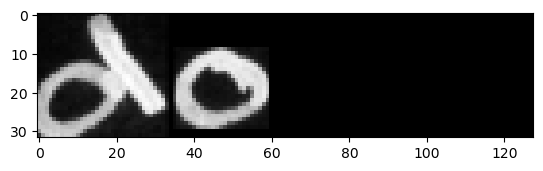

In [8]:
import matplotlib.pyplot as plt # Imports the matplotlib library

plt.imshow(train_images[647], cmap='gray') # Uses matplotlib to display the image. Use cmap='gray' for grayscale images
plt.show()

In [9]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [10]:
valid_padded_label[23]

array([67, 69, 66, 67, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78])

In [11]:
train_padded_label.shape, valid_padded_label.shape

((23761, 17), (2644, 17))

In [12]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [13]:
train_images.shape

(23761, 32, 128, 1)

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
import Levenshtein

In [15]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 1))(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 1))(x)
    
    # Reshape for RNN
    x = layers.Reshape((-1, x.shape[-1]))(x)


    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3))(x)

    

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

In [16]:
input_shape = (32, 128, 1)
num_classes = len(char_list) + 1  # +1 for CTC blank
model = create_model(input_shape, num_classes)

In [17]:
# CTC loss function
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [332]:
class AccuracyCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, char_list, max_label_len):
        super(AccuracyCallback, self).__init__()
        self.validation_data = validation_data
        self.char_list = char_list
        self.max_label_len = max_label_len

    def calculate_cer(self, ground_truth, predicted):
        """Calculates the Character Error Rate (CER)."""
        edit_distance = Levenshtein.distance(ground_truth, predicted)
        cer = edit_distance / len(ground_truth)
        return cer

    def calculate_wer(self, ground_truth, predicted):
        """Calculates the Word Error Rate (WER)."""
        ground_truth_words = ground_truth.split()
        predicted_words = predicted.split()
        edit_distance = Levenshtein.distance(ground_truth_words, predicted_words)
        wer = edit_distance / len(ground_truth_words)
        return wer

    def decode_predictions(self, predictions):
        """Decodes predictions using CTC decoding."""
        input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
        results = keras.backend.ctc_decode(predictions,
                                           input_length=input_len,
                                           greedy=True)[0][0]
        decoded_texts = []
        for result in results:
            decoded_text = ''.join([self.char_list[int(i)] for i in result if int(i) != -1])
            decoded_texts.append(decoded_text)
        return decoded_texts

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        decoded_texts = self.decode_predictions(predictions)

        total_cer = 0
        total_wer = 0
        num_samples = len(decoded_texts)

        # Prepare validation ground truth texts
        y_val_texts = []
        for y in y_val:
          text = ''.join([self.char_list[int(i)] for i in y if int(i) != len(self.char_list)])
          y_val_texts.append(text)


        for i in range(num_samples):
            cer = self.calculate_cer(y_val_texts[i], decoded_texts[i])
            wer = self.calculate_wer(y_val_texts[i], decoded_texts[i])
            total_cer += cer
            total_wer += wer

        avg_cer = total_cer / num_samples
        avg_wer = total_wer / num_samples

        print(f"-Character Acc: {((1-avg_cer)*100):.4f}% -Word Acc: {((1-avg_wer)*100):.4f}%")

In [333]:
accuracy_callback = AccuracyCallback(validation_data=(valid_images, valid_padded_label), char_list=char_list, max_label_len=max_label_len)

In [334]:
model.compile(optimizer='adam', loss=ctc_loss)

In [335]:
# Train the model
history = model.fit(
    x=train_images,
    y=train_padded_label,
    validation_data=(valid_images, valid_padded_label),
    batch_size=32,
    epochs=25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "best_model.keras",
            save_best_only=True,
            monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(
            patience=3,
            monitor="val_loss"
        ),
        accuracy_callback  # Add the AccuracyCallback
    ]
)

Epoch 1/25
83/83 [==============================] - 3s 21ms/step
-Character Acc: 31.2033% -Word Acc: 17.7005%
743/743 [==============================] - 108s 138ms/step - loss: 13.7821 - val_loss: 11.8212
Epoch 2/25
83/83 [==============================] - 2s 21ms/step
-Character Acc: 60.7458% -Word Acc: 33.3585%
743/743 [==============================] - 95s 128ms/step - loss: 8.7621 - val_loss: 6.9446
Epoch 3/25
83/83 [==============================] - 2s 21ms/step
-Character Acc: 77.6515% -Word Acc: 48.2980%
743/743 [==============================] - 95s 128ms/step - loss: 5.0747 - val_loss: 3.9783
Epoch 4/25
83/83 [==============================] - 2s 21ms/step
-Character Acc: 81.7637% -Word Acc: 55.4085%
743/743 [==============================] - 95s 128ms/step - loss: 3.2660 - val_loss: 3.2761
Epoch 5/25
83/83 [==============================] - 2s 21ms/step
-Character Acc: 86.3825% -Word Acc: 61.9516%
743/743 [==============================] - 98s 132ms/step - loss: 2.4476 - val_

In [340]:
# Save the model in SavedModel format
model.save('ocr_model_saved.keras')

In [ ]:
loaded_model = keras.models.load_model('C:\AI Models\OCR_Model\ocr_model_saved.keras', custom_objects={'ctc_loss': ctc_loss})

In [ ]:
image_path=r'C:\AI Models\OCR_Model\test-image.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = process_image(img)

pic = np.asarray(img)
plt.imshow(pic, cmap=plt.cm.gray)
plt.show()
print(' ')

img = np.expand_dims(img, axis=0)
prediction = loaded_model.predict(img)
input_len = np.ones(prediction.shape[0]) * prediction.shape[1]
results = keras.backend.ctc_decode(prediction,
                                    input_length=input_len,
                                    greedy=True)[0][0]

output_text = []
for result in results:
    result = ''.join([char_list[int(i)] for i in result if int(i) != -1])
    output_text.append(result)

predicted_text=output_text[0]
print(f"Predicted text: {predicted_text}")